1-Day 95 % VaR  : 0.6889
1-Day 95 % CVaR : 0.8634


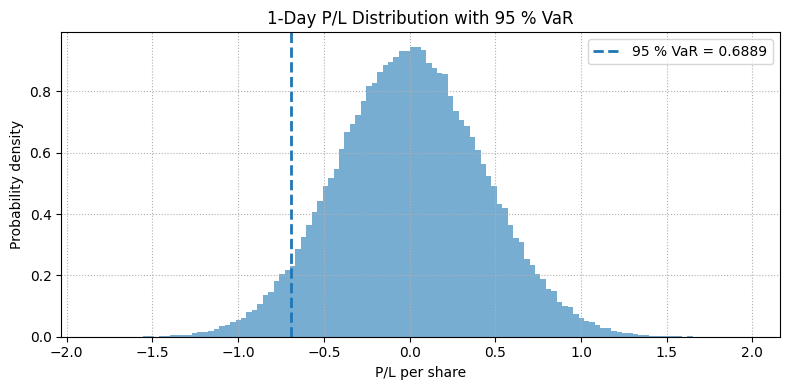

In [1]:
"""
Monte-Carlo VaR engine for a single stock driven by Geometric Brownian Motion.

1. Simulates price paths with `simulate_multiple_paths`.
2. Computes horizon-specific VaR and CVaR with `monte_carlo_var`.
3. Provides a quick demo and visual diagnostics when run as a script.

Author: ChatGPT (June-2025)
"""

import numpy as np
import matplotlib.pyplot as plt


# ────────────────────────────────────────────────────────────────────
# 1  Path simulation (unchanged except for vectorised inner loop)
# ────────────────────────────────────────────────────────────────────
def simulate_multiple_paths(
    S0: float,
    sigma: float,
    r: float,
    T: float,
    N: int,
    paths: int,
    random_seed: int | None = None,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Simulate `paths` geometric-Brownian-motion trajectories.

    Returns
    -------
    times      : (N+1,) array of time grid points
    all_paths  : (paths, N+1) array with each row a simulated path
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    dt     = T / N
    times  = np.linspace(0.0, T, N + 1)
    drift  = (r - 0.5 * sigma**2) * dt
    diff   = sigma * np.sqrt(dt)

    # pre-sample all Zs in one shot for speed → shape (paths, N)
    Z = np.random.normal(size=(paths, N))
    increments = drift + diff * Z                                 # (paths, N)
    log_paths  = np.cumsum(np.hstack([np.zeros((paths, 1)), increments]), axis=1)
    all_paths  = S0 * np.exp(log_paths)                           # convert from ln-space

    return times, all_paths


# ────────────────────────────────────────────────────────────────────
# 2  VaR / Expected-Shortfall utility
# ────────────────────────────────────────────────────────────────────
def monte_carlo_var(
    S0: float,
    sigma: float,
    r: float,
    H_days: int = 1,
    alpha: float = 0.95,
    paths: int = 100_000,
    seed: int | None = None,
) -> tuple[float, float]:
    """
    Monte-Carlo Value-at-Risk (VaR) and Conditional VaR (CVaR).

    Parameters
    ----------
    H_days : int       Horizon in trading days (1 day ≈ 1/252 years)
    alpha  : float     Confidence level (e.g. 0.95 → 95 % VaR)
    paths  : int       Number of MC paths

    Returns
    -------
    VaR  : positive float (loss ≥ VaR occurs with probability 1-alpha)
    CVaR : positive float (average loss if VaR barrier is breached)
    """
    # Step 1: simulate only up to the VaR horizon
    T = H_days / 252.0
    _, paths_arr = simulate_multiple_paths(S0, sigma, r, T, N=1, paths=paths, random_seed=seed)

    # Step 2: P/L distribution
    pnl = paths_arr[:, -1] - S0                                   # per-share P&L

    # Step 3: VaR & CVaR
    var  = -np.percentile(pnl, 100 * (1 - alpha))
    cvar = -pnl[pnl <= -var].mean()

    return var, cvar


# ────────────────────────────────────────────────────────────────────
# 3  Quick demo when executed directly
# ────────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    # --- Model parameters
    S0     = 31.00
    sigma  = 0.21805
    r      = 0.0495
    paths  = 100_000
    seed   = 42

    # --- Compute 1-day 95 % VaR & CVaR
    var95, es95 = monte_carlo_var(S0, sigma, r, H_days=1, alpha=0.95, paths=paths, seed=seed)
    print(f"1-Day 95 % VaR  : {var95:,.4f}")
    print(f"1-Day 95 % CVaR : {es95:,.4f}")

    # --- Optional diagnostics: P/L histogram and VaR line
    #     (comment out the block if running headless)
    final_prices = simulate_multiple_paths(S0, sigma, r, T=1/252, N=1,
                                           paths=paths, random_seed=seed)[1][:, -1]
    pnl = final_prices - S0

    plt.figure(figsize=(8, 4))
    plt.hist(pnl, bins=120, density=True, alpha=0.6)
    plt.axvline(-var95, linestyle="--", linewidth=2, label=f"95 % VaR = {var95:,.4f}")
    plt.title("1-Day P/L Distribution with 95 % VaR")
    plt.xlabel("P/L per share")
    plt.ylabel("Probability density")
    plt.legend()
    plt.grid(True, linestyle=":")
    plt.tight_layout()
    plt.show()
